## 1] Import modules

In [2]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision import transforms as T
from torchvision.datasets import ImageFolder

import os
import numpy as np
import seaborn as sns
import pandas as pd

from tqdm import tqdm
from PIL import Image
from torchinfo import summary

import math
import matplotlib.pyplot as plt

from sklearn import metrics

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2] Data Prepocessing

### Device and other Configuration

In [31]:
class Config:
    train_dir :str = '/kaggle/input/indian-birds/Birds_25/train'
    val_dir :str = '/kaggle/input/indian-birds/Birds_25/valid'
    
    train_class :np.array = np.array(sorted(os.listdir(train_dir)))
    n_class :int = len(train_class)
    
    in_channel :int = 3
    image_size :int = 224
    patch_size :int = 16
    d_model :int = 1024
    d_ff :int = 3072
    batch_size :int = 64
    
    lr :float = 1e-3
    dropout :float = 0.4

    n_block :int = 8
    head_size :int = 16

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_to_gpu(model:nn.Module, device:torch.device) -> nn.Module:
    count = torch.cuda.device_count()
    if count > 1:
        print(f"Using {count} {device} device !!")
        model = model.to(device)
        model = nn.DataParallel(model)
        return model
    else:
        print(f"Using {device} device !!")
        model = model.to(device)
        return model

### Dataset and DataLoader

In [5]:
transform = T.Compose([
    T.Resize((Config.image_size,Config.image_size)),
#     T.RandomAutocontrast(0.2),
#     T.CenterCrop((Config.image_size,Config.image_size)),
    T.ToTensor()
])

In [ ]:
train_dataset = ImageFolder(root = Config.train_dir, transform = transform)
val_dataset = ImageFolder(root = Config.val_dir, transform = transform)

train_dataloader = DataLoader(train_dataset, Config.batch_size, shuffle=True, pin_memory=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, Config.batch_size, shuffle=True, pin_memory=True, num_workers=2)

Asian-Green-Bee-Eater


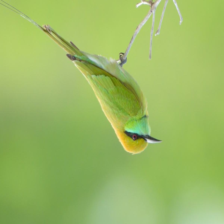

In [7]:
image, label = train_dataset[300]
print(Config.train_class[label])
T.ToPILImage()(image)

## 3] Model (ViT)

In [8]:
class PatchEmbedding(nn.Module):

    def __init__(self,in_channels:int=3,patch_size:int=16,embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        self.patcher = nn.Conv2d(in_channels=in_channels,out_channels=embedding_dim,kernel_size=patch_size,stride=patch_size,padding=0)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):

        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        return x_flattened.permute(0, 2, 1) 

In [9]:
class SelfAttention(nn.Module):
    def forward(self, q:torch.Tensor, k:torch.Tensor, v:torch.Tensor, mask:any = None) -> torch.Tensor:
        d_k = q.size(-1)
        attention = q @ k.transpose(-2, -1) / math.sqrt(d_k)
        
        if mask is not None:
            attention.masked_fill_(mask == 0, -1e9)
        
        attention = attention.softmax(dim= -1)

        attention = attention @ v
        
        return attention

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model:int, seq_len:int, head_size:int, dropout:float = 0.2) -> torch.Tensor:
        super().__init__()

        self.d_model = d_model
        self.seq_len = seq_len
        self.head_size = head_size

        assert d_model % head_size == 0, "d_model is divisible by the head_size"
        self.d_k = d_model // head_size

        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)

        self.wo = nn.Linear(d_model, d_model, bias=False)

        self.attention = SelfAttention()

        self.dropout = nn.Dropout(dropout)

    def forward(self, q:torch.Tensor, k:torch.Tensor, v:torch.Tensor, mask=None) -> torch.Tensor:

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        #(b, seq_len, d_model) -> (b, seq_len, head, d_k) -> (b, head, seq_len, d_k)
        query = q.view(q.size(0), q.size(1), self.head_size, self.d_k).transpose(1, 2) 
        key = k.view(k.size(0), k.size(1), self.head_size, self.d_k).transpose(1, 2)
        value = v.view(v.size(0), v.size(1), self.head_size, self.d_k).transpose(1, 2)

        attention = self.attention(query, key, value, mask)
        
        out = attention.transpose(1, 2).contiguous().view(attention.size(0), -1, self.d_model)

        out = self.wo(out)

        return out

In [11]:
class FeedForward(nn.Module):
    def __init__(self, d_model:int, d_ff:int, dropout:float = 0.2) -> None:
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x:torch.Tensor) -> torch.Tensor:

        x = self.linear_1(x)
        x = self.dropout(x)
        out = self.linear_2(x)

        return out

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model:int, d_ff:int, seq_len:int, head_size:int, dropout:float) -> None:
        super().__init__()

        self.layernorm1 = nn.LayerNorm(d_model)
        self.multiheadattention = MultiHeadAttention(d_model, seq_len, head_size, dropout)
        
        self.layernorm2 = nn.LayerNorm(d_model)
        self.feedforward = FeedForward(d_model ,d_ff, dropout)
        self.active = nn.GELU()
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:

        res = x
        x = self.layernorm1(x)
        x = self.multiheadattention(x, x, x)
        x += res

        res = x
        x = self.layernorm2(x)
        x = self.feedforward(x)
        x = self.active(x)
        x += res

        return x

In [ ]:
class ViT(nn.Module):
    def __init__(self, in_channel: int, num_patch: int, N_block: int, d_model: int, d_ff: int, head_size: int, dropout: float) -> None:
        super().__init__()
        
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model),requires_grad=True)
        
        self.patchembedding = PatchEmbedding(in_channel, num_patch, d_model)
        seq_len = (Config.image_size // Config.patch_size) ** 2
        self.encoders = nn.ModuleList([EncoderBlock(d_model, d_ff, seq_len, head_size, dropout) for _ in range(N_block)])
        
        self.class_layer = nn.Linear(d_model, Config.n_class)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
 
        x = self.patchembedding(x)  
        for layer in self.encoders:
            x = layer(x)
        
        x = x[:, 0, :]
        x = self.class_layer(x)
        
        return x

In [32]:
model = ViT(
            in_channel = Config.in_channel, 
            num_patch = Config.patch_size, 
            N_block = Config.n_block, 
            d_model = Config.d_model, 
            d_ff = Config.d_ff,
            head_size = Config.head_size,
            dropout = Config.dropout
           )

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_normal_(p)

model = torch.compile(model)
model = load_to_gpu(model, device)
summary(model, (Config.batch_size,Config.in_channel,Config.image_size,Config.image_size))

Using 2 cuda device !!


Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       [64, 25]                  --
├─ViT: 1-1                                         [32, 25]                  84,765,721
├─ViT: 1-4                                         --                        (recursive)
│    └─PatchEmbedding: 2-1                         [32, 196, 1024]           787,456
│    └─PatchEmbedding: 2-6                         --                        (recursive)
│    │    └─Conv2d: 3-1                            [32, 1024, 14, 14]        787,456
├─ViT: 1-3                                         [32, 25]                  --
├─ViT: 1-4                                         --                        (recursive)
│    └─PatchEmbedding: 2-3                         [32, 196, 1024]           --
│    └─PatchEmbedding: 2-6                         --                        (recursive)
│    │    └─Conv2d: 3-2                            [32, 1024,

## 4] Train The Model

In [18]:
def train(model: nn.Module, dataloader:DataLoader, optim:optim, loss_fn:nn, device:torch.device) -> list:
    model.train()
    pbar = tqdm(dataloader, desc="Training")
    
    for image,label in pbar:
        
        image, label = image.to(device, non_blocking=True), label.to(device, non_blocking=True)
        
        pred = model(image)
        
        loss = loss_fn(pred, label)
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        pred = pred.argmax(dim=1)
        
        label, pred = label.to("cpu"), pred.to("cpu")
        acc = metrics.accuracy_score(label.numpy(),pred.numpy())
        precision = metrics.precision_score(label.numpy(), pred.numpy(), average='weighted', zero_division=0)
        recall = metrics.recall_score(label.numpy(), pred.numpy(), average='weighted', zero_division=0)
        
        pbar.set_postfix(Accuracy = acc, Loss = loss.item(), Precision = precision, Recall = recall)
    
    return acc, loss.item(), precision, recall

In [19]:
def valid(model:nn.Module,val_loader:DataLoader, device:torch.device):
    model.eval()
    val_loss = 0 
    with torch.no_grad():
        for image,labels in val_loader:
            
            image , labels = image.to(device, non_blocking=True),labels.to(device, non_blocking=True)
            output = model(image)
            
            val_loss += F.cross_entropy(output, labels, reduction='sum').item() 
            pred = output.argmax(dim=1,keepdim=True)
            
            labels , pred = labels.to('cpu') , pred.to('cpu')
            
            acc = metrics.accuracy_score(labels.numpy(),pred.numpy())
            precision = metrics.precision_score(labels.numpy(),pred.numpy() , average='weighted', zero_division=0)
            recall = metrics.recall_score(labels.numpy(),pred.numpy(), average='weighted', zero_division=0)
            
    val_loss /= len(val_loader.dataset)
    
    
    print(f'|| Validation Loss = {val_loss:0.4f} || Validation Accuracy = {acc:0.4f} || Validation Precision = {precision:0.4f} || Validation Recall = {recall:0.4f} ||')
    
    return acc, val_loss, precision, recall

In [20]:
def update_metrics(metrics:dict, train_list:list, val_list) -> None:
    metrics['accuracy'].append(train_list[0])
    metrics['val_accuracy'].append(val_list[0])
    
    metrics['loss'].append(train_list[1])
    metrics['val_loss'].append(val_list[1])
    
    metrics['precision'].append(train_list[2])
    metrics['val_precision'].append(val_list[2])
    
    metrics['recall'].append(train_list[3])
    metrics['val_recall'].append(val_list[3])

### Loss and Optim

In [42]:
optimizer = optim.AdamW(model.parameters(),lr=Config.lr, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

In [34]:
metric = {
    'accuracy':[],'val_accuracy':[],
    'loss':[],'val_loss':[],
    'precision':[],'val_precision':[],
    'recall':[],'val_recall':[]
}

In [43]:
EPOCH = 40
for epoch in range(EPOCH):
    print(f'EPOCH: [{epoch+1} / {EPOCH}]')
    train_ans = train(model, train_dataloader, optimizer, loss_fn, device)
    val_ans = valid(model, val_dataloader, device)
    update_metrics(metric, train_ans, val_ans) # temp function for look train and valid loop clear

EPOCH: [1 / 40]


Training: 100%|██████████| 469/469 [07:44<00:00,  1.01it/s, Accuracy=0.646, Loss=1.24, Precision=0.766, Recall=0.646] 


|| Validation Loss = 1.3326 || Validation Accuracy = 0.5625 || Validation Precision = 0.6431 || Validation Recall = 0.5625 ||
EPOCH: [2 / 40]


Training: 100%|██████████| 469/469 [07:43<00:00,  1.01it/s, Accuracy=0.771, Loss=1.04, Precision=0.872, Recall=0.771]   


|| Validation Loss = 1.0788 || Validation Accuracy = 0.8125 || Validation Precision = 0.8837 || Validation Recall = 0.8125 ||
EPOCH: [3 / 40]


Training: 100%|██████████| 469/469 [07:40<00:00,  1.02it/s, Accuracy=0.417, Loss=3.4, Precision=0.394, Recall=0.417]     


|| Validation Loss = 3.1871 || Validation Accuracy = 0.3750 || Validation Precision = 0.2584 || Validation Recall = 0.3750 ||
EPOCH: [4 / 40]


Training: 100%|██████████| 469/469 [07:40<00:00,  1.02it/s, Accuracy=0.458, Loss=2.12, Precision=0.413, Recall=0.458]


|| Validation Loss = 1.9300 || Validation Accuracy = 0.5208 || Validation Precision = 0.5406 || Validation Recall = 0.5208 ||
EPOCH: [5 / 40]


Training: 100%|██████████| 469/469 [07:40<00:00,  1.02it/s, Accuracy=0.667, Loss=1.51, Precision=0.622, Recall=0.667]


|| Validation Loss = 2.0037 || Validation Accuracy = 0.6250 || Validation Precision = 0.7361 || Validation Recall = 0.6250 ||
EPOCH: [6 / 40]


Training: 100%|██████████| 469/469 [07:41<00:00,  1.02it/s, Accuracy=0.583, Loss=1.78, Precision=0.577, Recall=0.583] 


|| Validation Loss = 1.5200 || Validation Accuracy = 0.6667 || Validation Precision = 0.6554 || Validation Recall = 0.6667 ||
EPOCH: [7 / 40]


Training: 100%|██████████| 469/469 [07:40<00:00,  1.02it/s, Accuracy=0.583, Loss=1.52, Precision=0.683, Recall=0.583] 


|| Validation Loss = 1.0127 || Validation Accuracy = 0.6250 || Validation Precision = 0.7448 || Validation Recall = 0.6250 ||
EPOCH: [8 / 40]


Training: 100%|██████████| 469/469 [07:40<00:00,  1.02it/s, Accuracy=0.708, Loss=1.25, Precision=0.785, Recall=0.708] 


|| Validation Loss = 0.9307 || Validation Accuracy = 0.6875 || Validation Precision = 0.7934 || Validation Recall = 0.6875 ||
EPOCH: [9 / 40]


Training: 100%|██████████| 469/469 [07:41<00:00,  1.02it/s, Accuracy=0.729, Loss=1.12, Precision=0.773, Recall=0.729] 


|| Validation Loss = 0.8177 || Validation Accuracy = 0.8333 || Validation Precision = 0.9062 || Validation Recall = 0.8333 ||
EPOCH: [10 / 40]


Training: 100%|██████████| 469/469 [07:41<00:00,  1.02it/s, Accuracy=0.646, Loss=1.2, Precision=0.749, Recall=0.646]  


|| Validation Loss = 0.6716 || Validation Accuracy = 0.8542 || Validation Precision = 0.8542 || Validation Recall = 0.8542 ||
EPOCH: [11 / 40]


Training: 100%|██████████| 469/469 [07:40<00:00,  1.02it/s, Accuracy=0.833, Loss=0.584, Precision=0.833, Recall=0.833]


KeyboardInterrupt: 

## 5] Testing and Evaluation

In [44]:
def plot_graph(ax, metrics1:list, metrics2:list, label:str) -> None:
    ax.plot(range(1, len(metrics1) + 1), metrics1, label=f'Training {label}', color='green', marker='o')
    ax.plot(range(1, len(metrics2) + 1), metrics2, label=f'Validation {label}', color='red', marker='o')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(f'{label.capitalize()}')
    ax.set_title(f'Training and validation {label.capitalize()}')
    ax.legend()
    ax.grid(True)

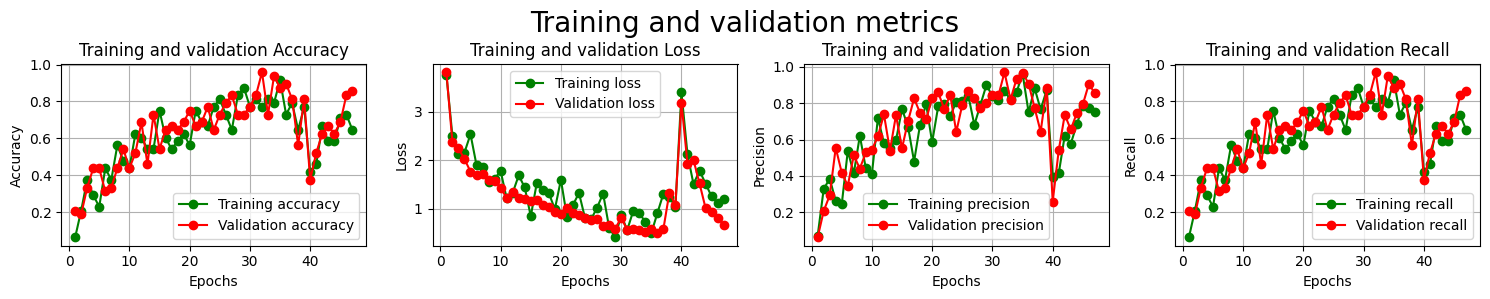

In [45]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))

# accuracy
plot_graph(ax1, metric['accuracy'], metric['val_accuracy'], 'accuracy')

# loss
plot_graph(ax2, metric['loss'], metric['val_loss'], 'loss')

# precision
plot_graph(ax3, metric['precision'], metric['val_precision'], 'precision')

# recall
plot_graph(ax4, metric['recall'], metric['val_recall'], 'recall')

fig.suptitle('Training and validation metrics', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.8)

plt.show()

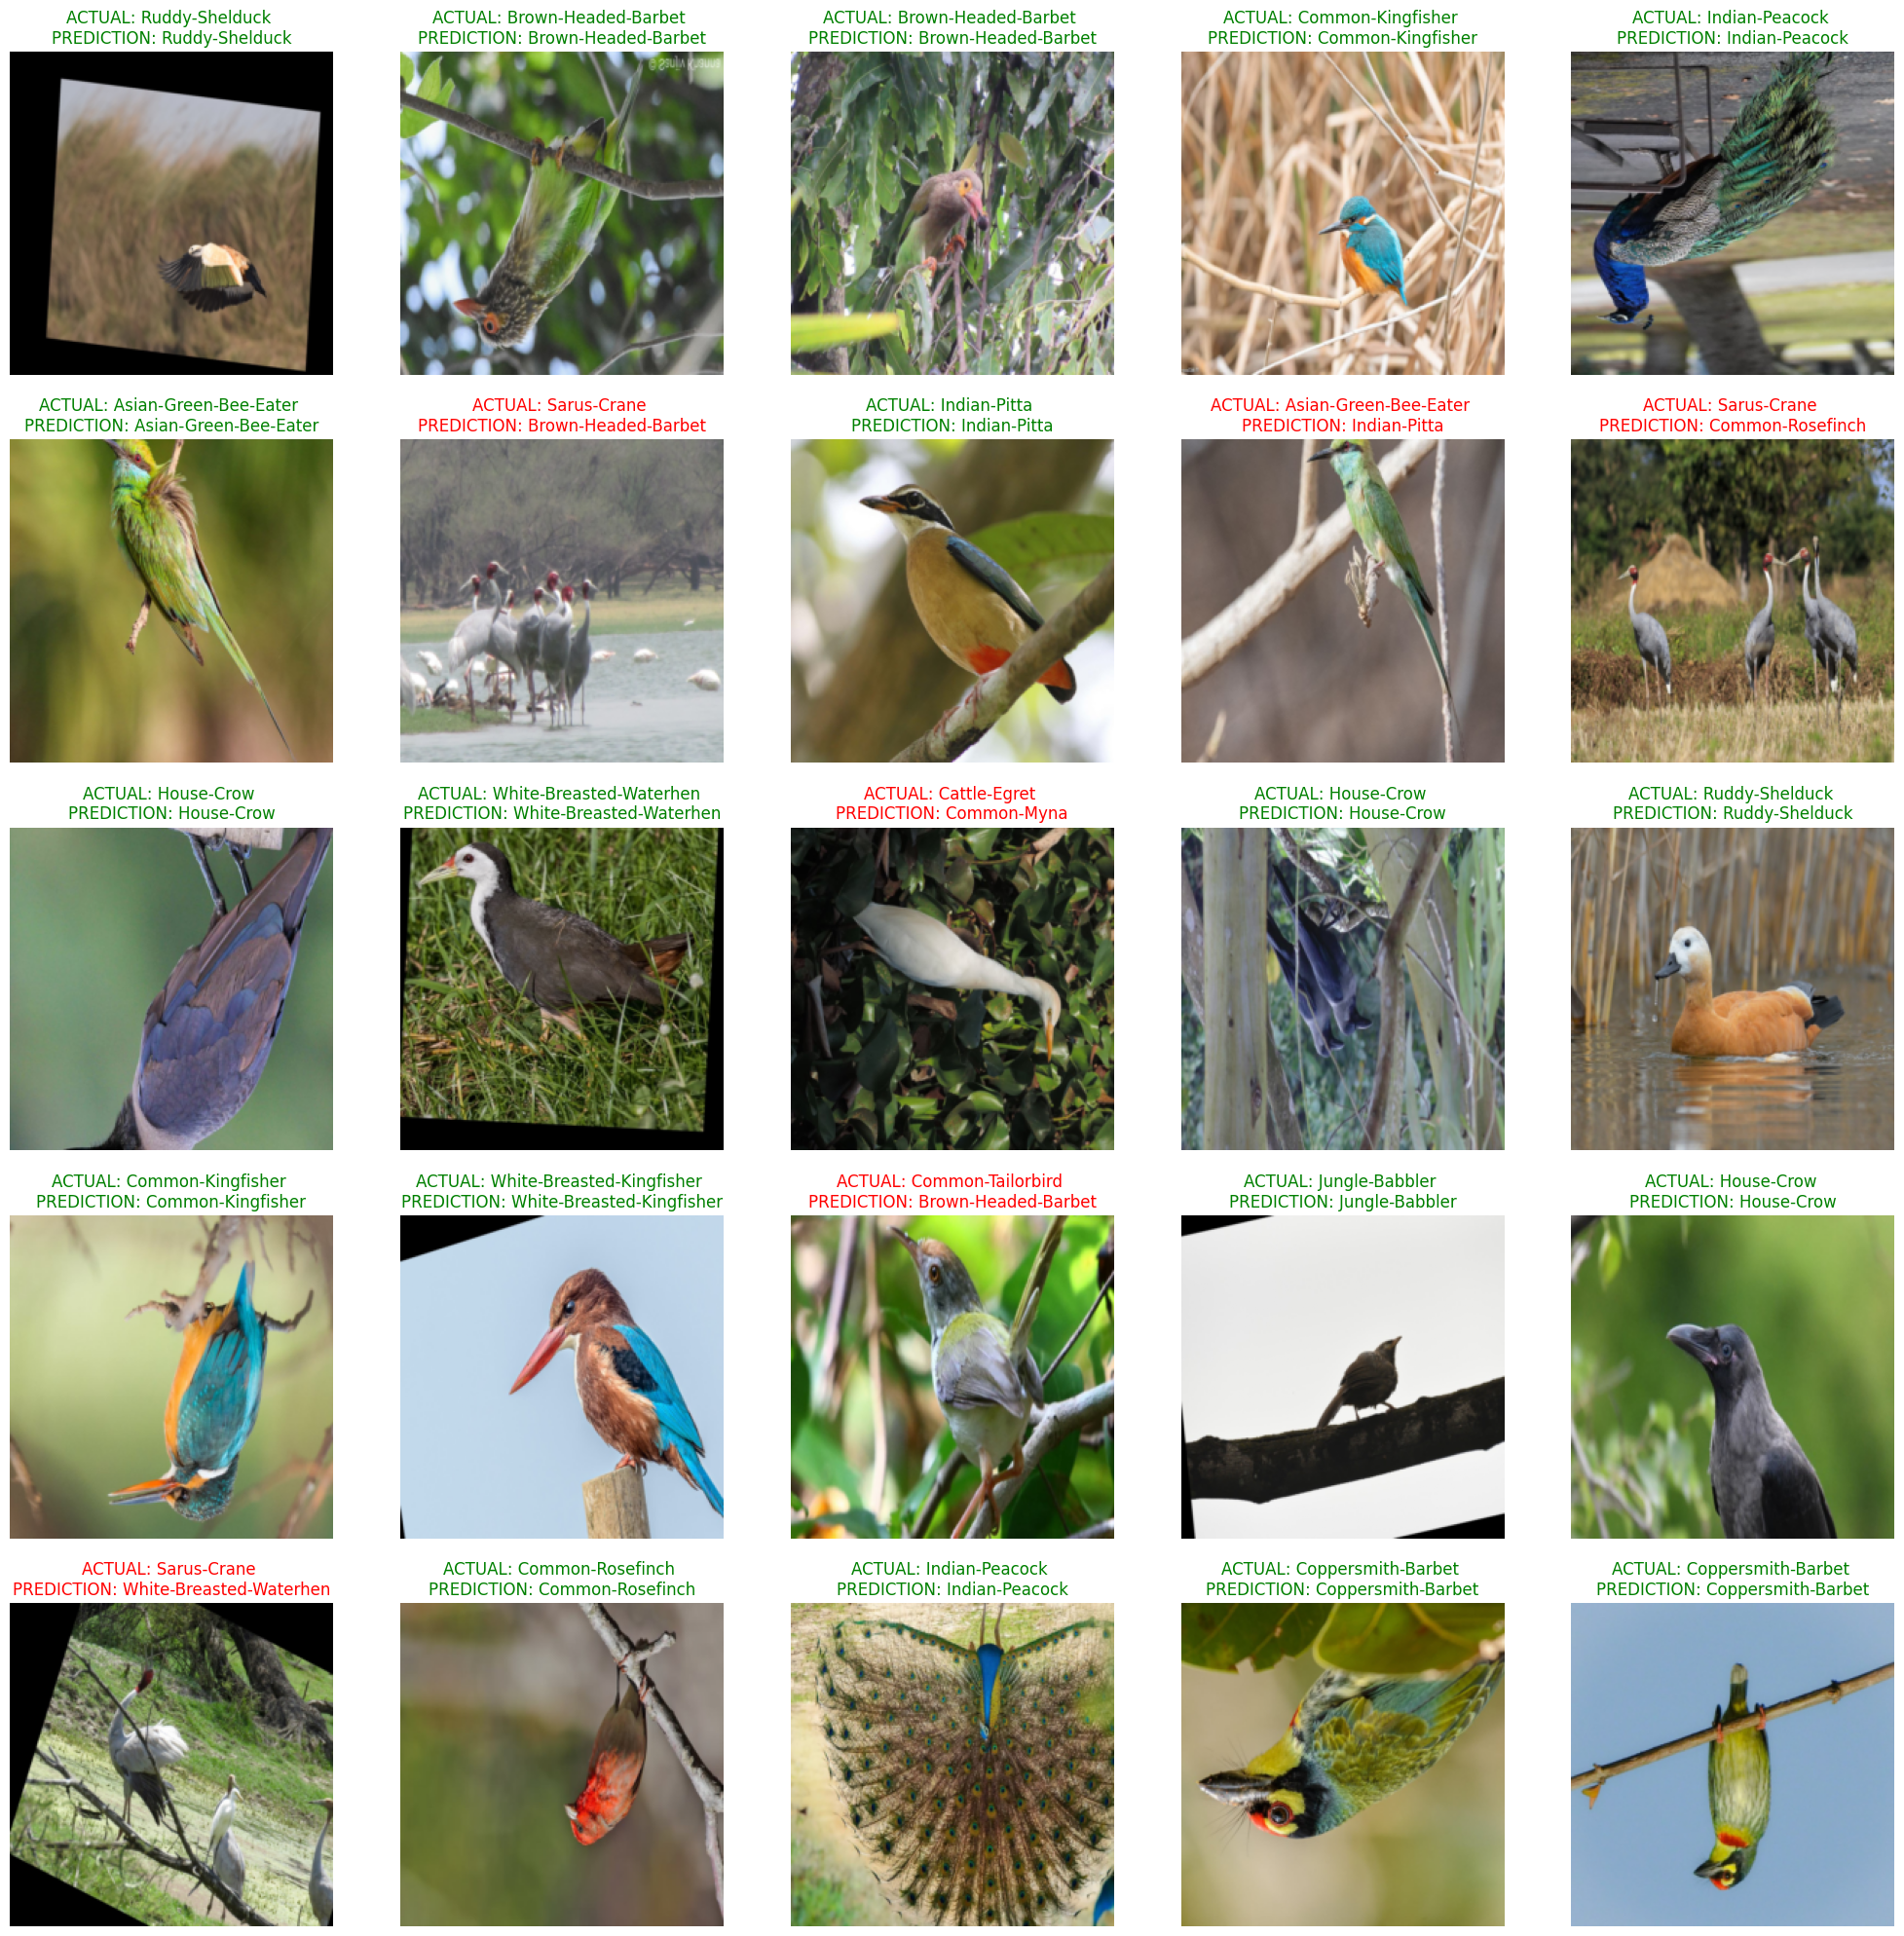

In [46]:
def show_prediction(model, dataloader):
    
    images,labels,preds = [],[],[]
    
    with torch.no_grad():
        for image,label in dataloader:
            image,label = image.to(device),label.to(device)
            
            pred = model(image).argmax(dim=1)
            
            images.append(image.cpu())
            labels.append(label.cpu().numpy().tolist())
            preds.append(pred.cpu().numpy().tolist())
            break
            
    fig , ax = plt.subplots(5,5,figsize=(25,25))
    ax = ax.flatten()
    
    images,labels,preds = images[0],labels[0],preds[0]
    for i in range(25):
        ax[i].imshow(images[i].permute(1, 2, 0))  
        color = 'green' if labels[i] == preds[i] else 'red'
        ax[i].set_title(
            f'ACTUAL: {Config.train_class[labels[i]]} \nPREDICTION: {Config.train_class[preds[i]]}',
            color=color
        )
        ax[i].axis('off') 
    plt.show()

show_prediction(model,val_dataloader)

In [47]:
def get_preds(model, dataloader):
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for image, label in tqdm(dataloader):
            image, label = image.to(device), label.to(device)

            pred = model(image)
            pred = pred.argmax(dim=1)
            
            preds.extend(pred.cpu().numpy().tolist())
            labels.extend(label.cpu().numpy().tolist())
    return preds, labels

preds, labels = get_preds(model, val_dataloader)

100%|██████████| 469/469 [03:57<00:00,  1.97it/s]


<Axes: title={'center': 'Confusion Matrix'}>

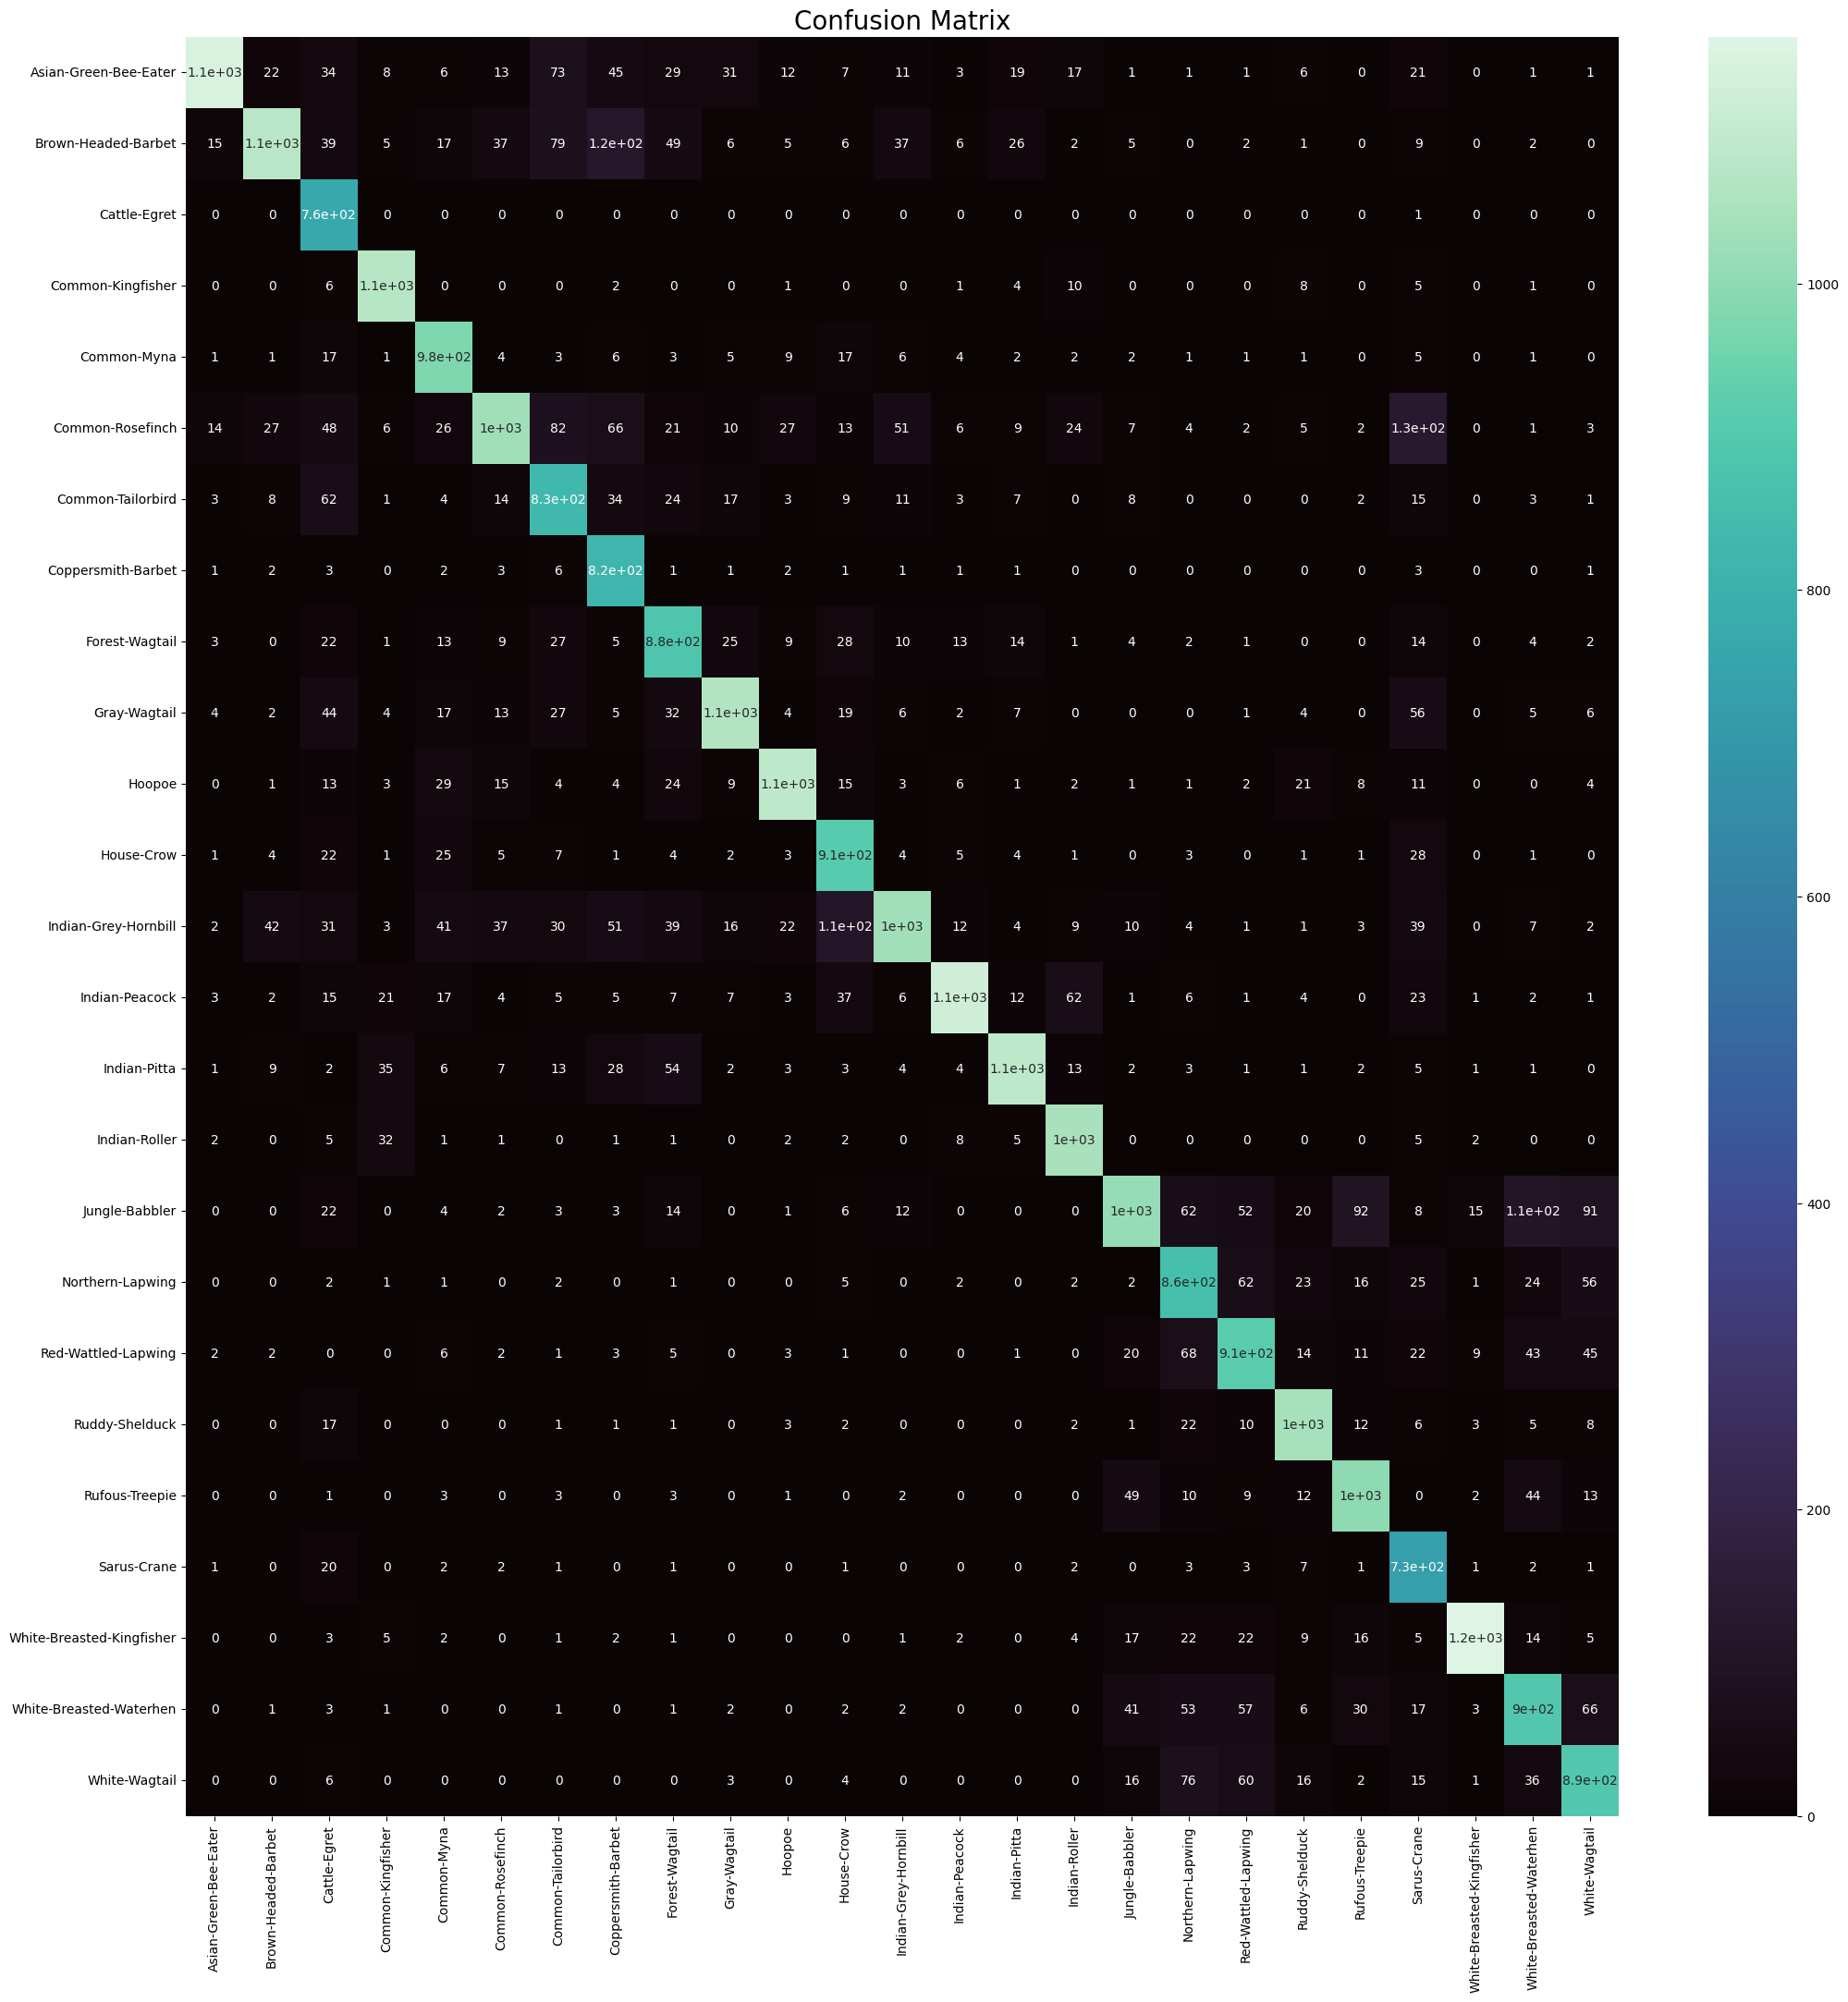

In [48]:
cm = metrics.confusion_matrix(preds, labels)  
df_cm = pd.DataFrame(cm,index = Config.train_class , columns = Config.train_class)
plt.figure(figsize=(25,25))

plt.title('Confusion Matrix',fontsize=20)
cmap = sns.color_palette("mako", as_cmap=True)

sns.heatmap(df_cm,annot=True,cmap=cmap)